# Аналитический проект для крупного сервиса проката самокатов GoFast

**Автор**: Милена Сайковская 

**Цель и задачи проекта**: проведение анализа демографии пользователей и особенностей использования самокатов, а также определение возможной выгоды от распространения платной подписки на самокаты.

---

## Часть 1. Загрузка данных

Для начала импортируем необхожимые библиотеки

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

Cчитаем и сохраним в отдельные датафреймы три CSV-файла. Датафреймы назовем в соответствии с названиями файлов, добавив префикс `df_`, например `df_users_go`. Для доступа к файлам используем следующие ссылки:

- https://code.s3.yandex.net/datasets/users_go.csv
- https://code.s3.yandex.net/datasets/rides_go.csv
- https://code.s3.yandex.net/datasets/subscriptions_go.csv

In [2]:
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

Выведем первые пять строк каждого датафрейма.
Познакомимся с содержанием таблиц.

In [3]:
display(df_users_go.head())
display(df_rides_go.head())
display(df_subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Определим количество строк в каждом из трёх датафреймов. Это поможет оценить объём данных и выявить аномалии, например слишком малое количество записей. 

In [4]:
display(df_users_go.shape[0], df_rides_go.shape[0], df_subscriptions_go.shape[0])

1565

18068

2

---

## Часть 2. Знакомство с данными и их предварительная подготовка

Прежде чем начать анализ, важно убедиться в качестве предоставленных данных. Выполним несколько шагов, чтобы лучше понять структуру и устранить потенциальные проблемы в таблицах.

В датафрейме `df_rides_go` выведем типы данных каждой колонки стандартным атрибутом `dtypes`. Так мы проверим корректность типов и подготовим данные для дальнейшей обработки.

In [5]:
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

Теперь приведем столбец `date` в датафрейме `df_rides_go` к типу даты pandas, используя метод `pd.to_datetime()`. Этот шаг упростит работу с временными данными.

In [6]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])

На основе столбца `date` создадим новый столбец `month`, содержащий номер месяца. Это нужно для последующей группировки данных и анализа сезонных трендов.

In [7]:
df_rides_go['month'] = df_rides_go['date'].dt.month

В датафрейме пользователей `df_users_go` определим количество пропусков и дубликатов. Это необходимо для понимания полноты и уникальности данных пользователей.

In [8]:
missing_values = df_users_go.isnull().sum().sum()
duplicated_values = df_users_go.duplicated().sum()

print(missing_values, duplicated_values)

0 31


Заполним пропущенные значения нулями, а все дубликаты удалим. Это шаг необходим для улучшения качества данных, что является ключевым для точного анализа. Все операции проведм с созданными в рамках первой задачи датафреймами.

In [9]:
df_rides_go = df_rides_go.drop_duplicates()
df_users_go = df_users_go.drop_duplicates()

В датафрейме поездок `df_rides_go` округлим время поездки `duration` до целого числа стандартным методом `round()`. Затем приведем эту колонку к целочисленному типу `int`. Этот шаг затем поможет правильно рассчитать прибыль, так как плата взимается только за целое число минут.

In [10]:
df_rides_go['duration'] = round(df_rides_go['duration']).astype(int)

---
## Часть 3. Исследовательский анализ данных (EDA)
Исследовательский анализ данных — неотъемлемая часть работы аналитика. В этом задании мы внимательнее изучим и визуализируем информацию о географии и демографии сервиса, а также лучше поймём закономерности в дистанциях и длительности поездок.

Пользуясь данными из датафрейма `df_users_go`, изучим количество пользователей в каждом из городов. Создадим и выведем на экран объект `pd.Series`, названный `users_by_city_count`, с одной колонкой `count` — суммарным количеством пользователей в каждом городе `city`, отсортированным по убыванию.

In [11]:
users_by_city_count = df_users_go['city'].value_counts()

print(users_by_city_count)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


Создадим и выведем на экран серию `subscription_type_count` с количеством пользователей для каждого типа подписки `subscription_type`.

In [12]:
subscription_type_count = df_users_go['subscription_type'].value_counts()

print(subscription_type_count)

subscription_type
free     835
ultra    699
Name: count, dtype: int64


Построим круговую диаграмму, указав процент пользователей с `free` и `ultra` подпиской. Вызовем метод `plot()` для серии `subscription_type_count` с указанием нужного аргумента для построения круговой диаграммы.

Затем добавим следующее:
- **Заголовок.** Установим заголовок с помощью параметра `title`, задав его как `'Соотношение пользователей с подпиской и без подписки'`.
- **Процентные метки.** Используем параметр `autopct='%.0f%%'` для отображения процентных значений на диаграмме. Достаточно передать аргумент в указанном виде методу `plot()`. Процентные метки часто хорошо дополняют круговые диаграммы.
- **Подпись оси Y.** Установим пустую строку для подписи оси Y `(ylabel='')`, чтобы она не отображалась.
- **Цвета секторов.** Используем параметр `colors`, задав красный цвет `red` для пользователей без подписки и зелёный `green` для подписчиков.

Затем вызовем `plt.show()` для отображения диаграммы.

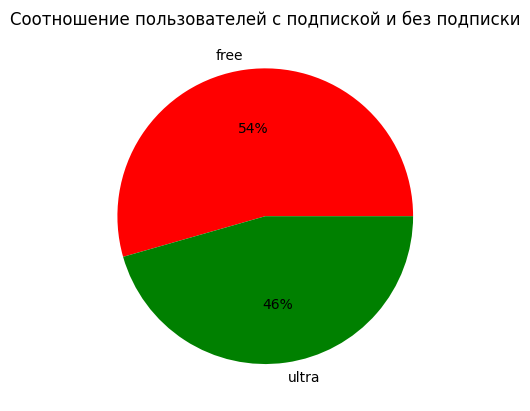

In [13]:
subscription_type_count.plot(
    kind= 'pie' ,
    title='Соотношение пользователей с подпиской и без подписки',
    autopct= '%.0f%%',
    ylabel= '',
    colors= ['red', 'green']
)

plt.show()

Построим гистограмму возрастов `age` пользователей самокатов. Используем количество бинов, равное разности максимального и минимального значений возраста.
Для этого выполним следующие действия:
1. Определим количество бинов `n_bins` как разницу между максимальным и минимальным значениями в столбце `age`.
2. Используем метод `hist()` для столбца `df_users_go['age']`.
3. Установим количество бинов через параметр `bins=n_bins`.
4. Назначим заголовок графика как `'Возраст пользователей'` с помощью `plt.title()`.
5. Установим подпись оси X как `'Возраст'` с помощью `plt.xlabel()`.
6. Вызовем `plt.show()` для визуального отображения гистограммы.

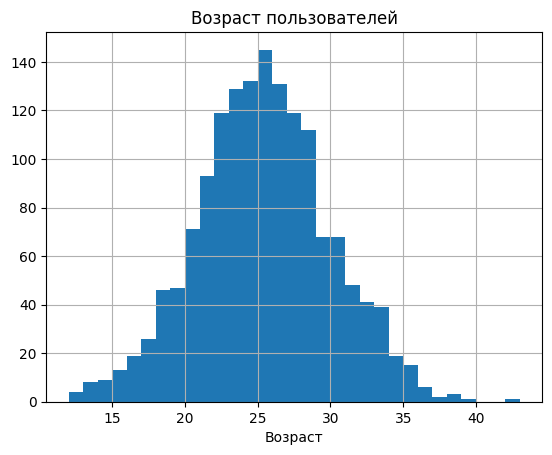

In [14]:
n_bins = max(df_users_go['age']) - min(df_users_go['age']) 

df_users_go['age'].hist(bins=n_bins)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')

plt.show()

Рассчитаем долю несовершеннолетних (возрастом менее 18 лет) пользователей самокатов. 
Для этого сначала необходимо рассчитать количество пользователей младше 18 лет — для этого применим принцип использования логических масок в pandas. Затем полученное значение разделим на количество строк в таблице. Получить его можно, например, из кортежа, который выдаёт атрибут <code>shape</code>.

In [15]:
users_under_18_ratio = round(100 * (df_users_go[df_users_go['age'] < 18].shape[0] / df_users_go.shape[0]))
print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')

Доля несовершеннолетних пользователей самокатов составляет 5%.


Длительность поездки является важной метрикой в работе сервиса проката самокатов. Если средняя длительность поездок будет слишком высокой, самокаты будут быстрее выходить из строя. Если слишком низкой, значит, клиентам что-то не нравится в сервисе.

С помощью описательной статистики изучим длительность поездок:

1. Используем колонку `duration` из датафрейма `df_rides_go`.
2. Расчитаем среднее значение и стандартное отклонение длительности поездки. Для расчёта стандартного отклонения можно воспользоваться методом `std()`.
3. Рассчитаем 25-й и 75-й процентили длительности поездки.

In [16]:
duration_mean = round(df_rides_go['duration'].mean())
duration_std = round(df_rides_go['duration'].std())

duration_pct25 = round(df_rides_go['duration'].quantile(0.25))
duration_pct75 = round(df_rides_go['duration'].quantile(0.75))

print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.


---
## Часть 4. Объединение данных

В самом начале урока вы загрузили три таблицы, настало время объединить все эти данные в один датафрейм.

Для начала объединим датафреймы с информацией о пользователях `df_users_go` и поездках `df_rides_go`. Полученный датафрейм назовем просто `df`. При объединении используем метод `merge()` по общей для двух таблиц колонке и тип объединения `left`.

In [17]:
df = pd.merge(df_rides_go, df_users_go, on='user_id', how='left')

Присоединим к полученному датафрейму `df` информацию о подписках из `df_subscriptions_go`, используя метод `merge()` по общей колонке и тип объединения `left`.

In [18]:
df = pd.merge(df, df_subscriptions_go, on='subscription_type', how='left')

Для финальной проверки выведем на экран первые пять строк датафрейма, а также количество строк и столбцов полученного датафрейма `df`. Этот этап позволит убедиться, что никакие записи не потерялись при объединении.

In [19]:
# Выводим первые строки датафрейма
display(df.head())

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows, n_cols = df.shape[0], df.shape[1]
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


Создадим два вспомогательных датафрейма на основе `df`: первый только для пользователей с подпиской `df_ultra` и второй только для пользователей без подписки `df_free`. Далее эти два этих датафрейма пригодятся при изучении поведения пользователей с подпиской и без, а также при проверке продуктовых гипотез.

In [20]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_free = df[df['subscription_type'] == 'free']

На одном графике построим гистограмму распределения длительности поездок `duration` для пользователей с подпиской и без.
Для этого выполним следующие этапы:
1. Установим размер графика: 15 по горизонтали и 5 по вертикали.
2. Отобразим данные из столбца `duration` датафрейма `df_free` с помощью метода `hist()`, задав количество бинов `bins=30` и метку `label='free'`.
3. Отобразим данные из столбца `duration` датафрейма `df_ultra` с помощью метода `hist()`, также задав количество бинов `bins=30` и метку `label='ultra'`.
4. Установим подпись оси X как `'Длительность поездки, мин.'`, используя `plt.xlabel()`.
5. Зададим заголовок графика как `'Гистограмма распределения длительности поездок'` методом `plt.title()`.
6. Добавим легенду для различения категорий на графике с использованием `plt.legend()`.
7. Вызовем `plt.show()` для показа графика пользователю.

Для удобства воспользуемся датафреймами, созданными на прошлом шаге, — `df_ultra` и `df_free`.

Дополнительно рассчитаем среднюю длительность поездки для пользователей с подпиской и без, округлив ее до целых стандартной функцией `round`.

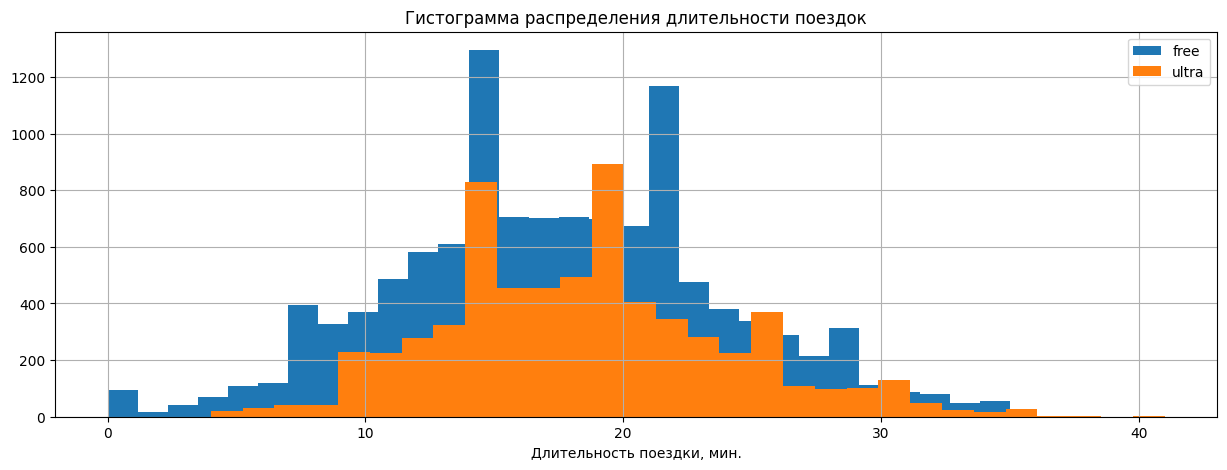

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [21]:
# Гистограмма длительности поездки для пользователей с подпиской и без
plt.figure(figsize=(15, 5))
df_free['duration'].hist(bins=30, label='free')
df_ultra['duration'].hist(bins=30, label='ultra')
plt.xlabel('Длительность поездки, мин.')
plt.title('Гистограмма распределения длительности поездок')
plt.legend()
plt.show()

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = round(df_free['duration'].mean())
mean_duration_ultra = round(df_ultra['duration'].mean())
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

---
## Часть 5. Подсчёт выручки
Данные о количестве и длительности поездок объединены с ценами и тарифами, а значит, теперь есть всё необходимое, чтобы рассчитать важный для бизнеса показатель — выручку.

Сгруппируем данные по следующим столбцам: `user_id`, `name`, `subscription_type`, `month`. Группировку призводем в датафрейме `df_gp`. (В итоговом датафрейме `df_gp` должен сохраниться порядок агрегации изначальных столбцов и не должны использоваться групповые индексы (опция `as_index=False`)).

In [22]:
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)

Создадим новый датафрейм `df_agg`. В нём для каждой группы рассчитаем и добавим в датафрейм следующие агрегированные значения, используя метод `agg()`:
- `total_distance` — сумма значений в столбце `distance`.
- `total_duration` — сумма значений в столбце `duration`.
- `rides_count` — количество элементов в столбце `duration`.
- `subscription_type` — первое значение в группе для столбца `subscription_type`.
- `minute_price` — первое значение в группе для столбца `minute_price`.
- `start_ride_price` — первое значение в группе для столбца `start_ride_price`.
- `subscription_fee` — первое значение в группе для столбца `subscription_fee`.

*для удобства сделаем агрегацию с использованием картежей*

In [23]:
df_agg = df_gp.agg( 
    total_distance=('distance', 'sum'),
    total_duration=('duration', 'sum'),
    rides_count=('duration', 'count'),
    subscription_type=('subscription_type', 'first'),
    minute_price=('minute_price', 'first'),
    start_ride_price=('start_ride_price', 'first'),
    subscription_fee=('subscription_fee', 'first')
)

Создадим функцию `calculate_monthly_revenue(row)` для расчёта месячной выручки по формуле:

`monthly_revenue` = `start_ride_price` * `rides_count` + `minute_price` * `total_duration` + `subscription_fee`

В качестве входных данных функция будет принимать одну строку `row` датафрейма.

Здесь:
- `start_ride_price * rides_count` — выручка от начала каждой поездки.
- `minute_price * total_duration` — выручка за время использования.
- `subscription_fee` — фиксированная выручка от подписок.

In [24]:
def calculate_monthly_revenue(row):
    monthly_revenue = (
        row['start_ride_price'] * row['rides_count'] + row['minute_price'] * row['total_duration'] + row['subscription_fee'])
    return(monthly_revenue)

Создадим новый столбец с месячной выручкой на пользователя `monthly_revenue`. Для этого применим функцию `calculate_monthly_revenue(row)` к каждой строке агрегированного датафрейма `df_agg`.

In [25]:
df_agg['monthly_revenue'] =  df_agg.apply(calculate_monthly_revenue, axis=1)

Исследуем полученные значения выручки. Найдем пользователя с максимальной суммарной выручкой за весь период наблюдения и для него выведем на экран `user_id`, имя, месяц, количество поездок и выручку за каждый из месяцев.

In [27]:
# сгруппируем df_agg по user_id и агрегируем (суммируем) monthly_revenue, 
# на этом же этапе отсортируем результат по убыванию и возьмем индекс первой записи (=сохраним в переменную)
max_user_id = df_agg.groupby('user_id')['monthly_revenue'].sum().sort_values(ascending=False).index[0] 
# Дальше просто отфильруем по user_id и выведем нужные столбцы
display(df_agg.query('user_id == @max_user_id')[['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']])

,user_id,name,month,rides_count,monthly_revenue
8877,1236,Александр,1,2,228
8878,1236,Александр,2,3,614
8879,1236,Александр,3,5,762
8880,1236,Александр,4,1,202
8881,1236,Александр,5,3,574
8882,1236,Александр,6,1,282
8883,1236,Александр,7,1,290
8884,1236,Александр,8,2,452
8885,1236,Александр,9,1,122
8886,1236,Александр,10,3,430


---
## Часть 6. Проверка гипотез

Напишем вспомогательную функцию `print_stattest_results(p_value, alpha)`, которая будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). Функция должна решать, следует ли принять альтернативную гипотезу или сохранить нулевую гипотезу.

У функции два параметра:
- `p_value` (тип `float`) — значение p-value, полученное в результате выполнения статистического теста.
- `alpha` (тип `float`, необязательный, по умолчанию `alpha = 0.05`) — уровень значимости статистического теста, который используется как порог для принятия решения об отклонении нулевой гипотезы.

Если мы принимаем альтернативную гипотезу, нужно вывести сообщение:
`'Полученное значение p_value=<Введённое значение p_value> меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.'`

Если мы не можем опровергнуть нулевую гипотезу, нужно вывести сообщение: `'Полученное значение p_value=<Введённое значение p_value> больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.'`

Вызовем функцию для `p_value = 0.0001` и `p_value = 0.1`.

In [29]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value < alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')
print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


Также важно понять, тратят ли пользователи с подпиской больше времени на поездки? Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза (Н0): Среднее время поездки у пользователей с подпиской и без подписки одинаковое.
- Альтернативная гипотеза (Н1): Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

Чтобы проверить эту гипотезу:
1. Используем неагрегированные данные из датафреймов `df_ultra` и `df_free`, созданные на одном из прошлых шагов.
2. Используем данные о продолжительности каждой поездки `duration` — отдельно для подписчиков и тех, у кого нет подписки.
3. Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
4. В качестве результата вызовем написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.
5. В конце дополнительно рассчитаем среднюю длительность поездки для тарифов `ultra` и `free`, округлив её до двух знаков после точки стандартной функцией `round()`.

In [30]:
ultra_duration = df_ultra['duration']
free_duration = df_free['duration']

results = st.ttest_ind(
    ultra_duration,
    free_duration,
    alternative='greater') 
p_value = results.pvalue

print_stattest_results(p_value)

ultra_mean_duration = round(ultra_duration.mean(), 2)
free_mean_duration = round(free_duration.mean(), 2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


Теперь проанализируем ещё одну важную продуктовую гипотезу. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.

- Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.

Чтобы проверить эту гипотезу:

1. Используем неагрегированные данные о каждой поездке пользователей с подпиской из датафрейма `df_ultra`.

2. Используем данные о дистанции каждой поездки `distance`.

3. Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.

4. В качестве результата вызовем написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.

In [31]:
null_hypothesis = 3130
ultra_distance = df_ultra['distance']

results = st.ttest_1samp(
    ultra_distance,
    null_hypothesis,
    alternative = 'greater')
p_value = results.pvalue

print_stattest_results(p_value)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


Теперь проверим гипотезу о том, что выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.
- Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.

Чтобы проверить эту гипотезу:
1. Используем агрегированные данные из датафрейма `df_agg`, подготовленного в 5 части проекта.
2. Используем исходные данные о месячной выручке от каждого пользователя — `monthly_revenue`.
3. Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
4. В качестве результата вызовем написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.
5. Дополнительно рассчитаем среднюю выручку для тарифов `ultra` и `free`, округлив её до целого стандартной функцией `round()`.

In [32]:
revenue_ultra = df_agg[df_agg['subscription_type']=='ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type']=='free']['monthly_revenue']

results = st.ttest_ind(
    revenue_ultra,
    revenue_free,
    alternative='greater'
    )
p_value = results.pvalue

print_stattest_results(p_value)

mean_revenue_ultra = round(revenue_ultra.mean())
mean_revenue_free = round(revenue_free.mean())

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя выручка подписчиков Ultra 359 руб
Средняя выручка подписчиков Free 322 руб


---
## Часть 7. Распределения

В компании возникла идея предлагать дополнительную скидку подписчикам, совершающим длительные поездки продолжительностью более 30 минут. Нас просят оценить долю таких поездок.

В одном из предыдущих заданий мы уже построили гистограмму распределения длительности поездок для выборки. Однако эти данные охватывают лишь часть пользователей всех самокатов, а нас интересуют возможные значения для всей генеральной совокупности. Учитывая, что у нас нет доступа ко всем данным о поездках, было решено смоделировать длительность поездки с помощью нормального распределения, используя в качестве параметров выборочное среднее и стандартное отклонение из доступных данных о поездках.

1. Расчитаем среднюю длительность поездки и сохраним в переменную `mu`.
2. Вычислим стандартное отклонение длительности `duration` и сохраним в переменную `sigma`. Для вычисления стандартного отклонения можно применить метод `std()` к столбцу датасета.
3. Зададим значение переменной `target_time`, равное `30`. Эта переменная будет использоваться для последующего вычисления вероятности.

In [33]:
# Вычисляем среднее значение
mu = df_ultra['duration'].mean()

# Вычисляем стандартное отклонение
sigma = df_ultra['duration'].std()

# Задаём целевое время
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


#### Вычисление значения функции распределения в точке (CDF)

Если вычислить значение функции распределения в точке, это позволит узнать вероятность того, что случайная величина примет значение меньше заданного либо равное ему. Соответственно, если мы хотите ответить на вопрос о вероятности поездки более 30 минут, потребуется использовать CDF.

1. Используем функцию `norm()` из библиотеки SciPy для создания нормального распределения с параметрами `mu` и `sigma`.

2. Применим метод `cdf()` к целевому времени `target_time` для получения вероятности того, что случайная величина будет меньше этого значения или равна ему. Полученное значение сохраним в переменную `prob`, округлив до трёх знаков после точки стандартной функцией `round()`.

In [34]:
# Вычисляем вероятность того, что случайная величина будет меньше указанного значения или равна ему

duration_norm_dist  = st.norm(mu, sigma)
prob = round(1 - duration_norm_dist.cdf(target_time), 3) # Используем CDF для нахождения накопленной вероятности

print(f'Вероятность поездки более 30 минут {prob}')

Вероятность поездки более 30 минут 0.02


#### Вероятность для интервала (CDF)
Коллеги посчитали, что процент пользователей, для которых будет показана скидка, недостаточно большой и вряд ли поможет в увеличении лояльности клиентов. Дополнительно yас просят проверить, какой процент пользователей совершает поездки в интервале от 20 до 30 минут. Возможно, именно для них стоит провести промоакцию?

Для этого:

1. Создадим переменные `low` и `high`, указывающие на начало и конец интересующего временного интервала. В этом случае они равны 20 и 30 минут.
2. Используем кумулятивную функцию распределения (CDF) для объекта `duration_norm_dist`, чтобы вычислить вероятность достижения верхней границы (`high`) и нижней границы (`low`).
3. Вычислим вероятность попадания в интервал, округлим до трёх знаков после точки стандартной функцией `round()` и сохраним в переменную `prob_interval`.

In [35]:
# Определяем границы интервала
low = 20
high = 30

# Вычисляем вероятность попадания в интервал
prob_interval = round(duration_norm_dist.cdf(high) - duration_norm_dist.cdf(low), 3)

# Выводим результат
print(f'Вероятность того, что пользователь совершит поездку длительностью от {low} до {high} минут: {prob_interval}')

Вероятность того, что пользователь совершит поездку длительностью от 20 до 30 минут: 0.377


#### Определение критической дистанции поездок (PPF)
Длительные поездки могут негативно сказываться на сроке службы самоката. В связи с этим принято решение установить критическую дистанцию, превышение которой будет сопровождаться дополнительной платой. Для этого необходимо определить расстояние, которое превышается только в 10% поездок (90-й процентиль).

Смоделируем распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитаем критическую дистанцию, ниже которой находится 90% всех поездок.

Для этого:
1. Рассчитаем среднюю дистанцию поездки для всех пользователей из датафрейма `df` (с подпиской и без) и сохраним в переменную `mu`.
2. Вычислим стандартное отклонение дистанции поездки `distance` и сохраним в переменную `sigma`. Для вычисления стандартного отклонения можно применить метод `std()` к столбцу датасета.
3. Зададим значение переменной `target_prob`, равное `0.90`. Эта переменная будет использоваться для последующего вычисления критической дистанции.
4. Создадим объект нормального распределения `distance_norm` с заданными значениями `mu` и `sigma`.
5. Применим к созданному нормальному распределению `distance_norm` метод `ppf()` и в качестве аргумента передадим целевую вероятность `target_prob`. Полученное значение сохраним в переменную `critical_distance`.

In [36]:
# Вычисляем среднее значение
mu = df['distance'].mean()

# Вычисляем стандартное отклонение
sigma = df['distance'].std()

# Вероятность, для которой хотим найти значение (90% случаев)
target_prob = 0.90

# Создаём объект нормального распределения
distance_norm = st.norm(mu, sigma)

# Рассчитываем критическую дистанцию для заданного процентиля поездок
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.


---
## Выводы и результаты:
Данный проект демонстрирует мое глубокое понимание статистических методов, а также умение справляться с задачами, используя CDF и PPF. Проведенный мной анализ помогает выявить ключевые характеристики распределения данных и определить критические значения, что очень ценно для принятия эффективных бизнес-решений.